# Notities

## Handige links
* [Statline portaal](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS)
* [Snelstartgids open data](https://www.cbs.nl/nl-nl/onze-diensten/open-data/statline-als-open-data/snelstartgids)
* [repo Github voor cbsodata](https://github.com/J535D165/cbsodata)
* [PyPi documentatis cbsodata](https://pypi.org/project/cbsodata/)
* [Sphinx docs cbsodata](https://cbsodata.readthedocs.io/en/latest/index.html)
* [GitHub voorbeelden OData 3](https://github.com/statistiekcbs/CBS-Open-Data-v3)
* [GitHub voorbeelden OData 4](https://github.com/statistiekcbs/CBS-Open-Data-v4/tree/master/Python)
* [Statline voor derden](https://www.cbs.nl/nl-nl/cijfers/statline/statline-voor-derden)
* [CBS open data Statline](https://opendata.cbs.nl/statline/portal.html?_la=nl&_catalog=CBS)
* [PDOK Viewer: Kies bij dataset voor CBS gebiedsindelingen (wijken staan helemaal onderaan) voor kaartweergave](https://www.pdok.nl/viewer/)

# Imports

In [1]:
import pandas as pd
import cbsodata

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Settings

In [30]:
GEMEENTES_REGIO_NIJMEGEN = ['Berg en Dal', 'Beuningen', 'Druten', 'Heumen', 'Mook en Middelaar', 'Nijmegen', 'Wijchen']

KEYWORDS = ['wmo', 'gemeente', 'regio', 'postcode', 'zorg', 'werk', 'lonen', 'loon', 'inkomen', 'conjunctuur', 
            'prognose', 'afstand', 'wijk', 'voorziening', 'genees', 'gezond']
URLS = ['opendata.cbs.nl', 'dataderden.cbs.nl']

CBS_OPEN_URL = 'opendata.cbs.nl'
WMO_TABLES = {'2020': '84907NED',
            '2019': '84664NED',
            '2018': '84421NED',
            '2017': '83818NED',
            '2016': '83620NED',
            '2015': '83267NED'}
WIJK_TABLES = {'2020': '84799NED', 
               '2019': '84583NED', 
               '2018': '84286NED', 
               '2017': '83765NED', 
               '2016': '83487NED', 
               '2015': '83220NED'} 
#                '2014': '82931NED'}

# Functies

In [17]:
def get_relevant_tables(url:str, 
                        keywords=[], 
                        frequency=['Eenmalig', 'Perjaar', 'Perkwartaal', 'Onregelmatig', 'Permaand', 'Pertweejaar', 'Perhalfjaar', 'Tweemaalperjaar'], 
                        select_columns=['ApiUrl','Identifier', 'ShortTitle','ColumnCount', 'RecordCount', 'Updated', 'Period', 'Summary', 'Frequency', 'ShortDescription', 'ExplanatoryText']):
    """
    Method to get relevant tables in the CBS database based on keywords in the title
    
    :params str url: URL of the catalog of the CBS databases, i.e.: 'opendata.cbs.nl'
    :params list[str] keywords: List of words to search for in the title.
    :params list[str] frequency: List of frequencies (level of accuracy in the data) where tables should be returned.
    :select_columns list[str] select_columns: Columns that should be included in the returned database. 
    """
    tables_list = cbsodata.get_table_list(catalog_url=url)
    df_tables = pd.DataFrame(tables_list)
    print(f"Total number of tables in this url is: {df_tables.shape[0]}")
    print(f"The columns in these tables are: {df_tables.columns}")
    total_identifier_list = []
    for keyword in keywords:
        identifier_list = [i['Identifier'] for i in tables_list if keyword.lower() in i['Title'].lower()]
        total_identifier_list = total_identifier_list + identifier_list
    columns_to_include = list(set(select_columns).intersection(df_tables.columns))
    df = df_tables[(df_tables['Identifier'].isin(total_identifier_list))&(df_tables['Frequency'].isin(frequency))][columns_to_include]
    return df

def get_and_combine_cbs_tables(dict_tables, url='opendata.cbs.nl'):
    """
    Method to get multiple simular tables in the CBS database.
    
    :params dict[str, str] tables: Dictionary with as key the period and as value the table name
    :params str url: URL of the catalog of the CBS databases, i.e.: 'opendata.cbs.nl'
    returns: pd.DataFrame
    """

    print(f"Number of tables to collect: {len(dict_tables)}")
    
    df= pd.DataFrame()
    for interval, table in dict_tables.items():
        print(f"Pythonic iteration {interval} for table {table}")
        try:
            df_sub = pd.DataFrame(cbsodata.get_data(table, catalog_url=url))
            df_sub['interval'] = interval
        except Exception:
            df_sub = pd.DataFrame()
            pass
        df = pd.concat([df, df_sub])
    return df

def rename_and_subset_cols(df, dict_rename, list_cols, include=True):
    
    df = df.rename(columns=dict_rename)
    if include:
        df = df[list_cols]
    else:
        df = df.drop(list_cols, axis=1)
    
    return df

def get_wmo_subtable(df, region=None, period=None, form=None):
    """
    Method to subset the dataframe with WMO data.
    
    :params pd.DataFrame df: DataFrame with the WMO data from CBS with the columns: 
                            [['codering_regio', 'perioden', 'financieringsvorm', 'wmoclienten', 'wmoclientenper1000inwoners']]
    :params str region: String to choose region. Possible strings are: "gemeente", "wijk"
    :params str period: String to choose period. Possible strings are: "jaar", "halfjaar" 
    :params str form: String to choose form of financing. Possible strings are: "totaal", "per type"
    returns: pd.DataFrame
    """
    
    if region == "gemeente":
        df = df[df.codering_regio.str.startswith('GM', na=False)]
    if region == "wijk":
        df = df[df.codering_regio.str.startswith('WK', na=False)]
    if region == "buurt":
        df = df[df.codering_regio.str.startswith('BU', na=False)]
    if period == "jaar":
        df = df[~df.perioden.str.contains("halfjaar", na=False)]
    if period == "halfjaar":
        df = df[df.perioden.str.contains("halfjaar", na=False)]
    if form == "totaal":
        df = df[df.financieringsvorm == "Totaal"]
    if form == "per type":
        df = df[df.financieringsvorm != "Totaal"]
    
    return df

def downcast_variables_dataframe(df):
    # Downcast dataset
    df[df.select_dtypes(include='object').columns] = df.select_dtypes(include='object').astype('category')

    for old, new in [('integer', 'unsigned'), ('float', 'float')]:
        for col in df.select_dtypes(include=old).columns:
            df[col] = pd.to_numeric(df[col], downcast=new)
    return df

# Explore possible tables

In [18]:
# General table list
toc = pd.DataFrame(cbsodata.get_table_list())
print(f"Shape of all tables: {toc.shape[0]}")
toc.sample(5)

Shape of all tables: 4887


,Updated,ID,Identifier,Title,ShortTitle,ShortDescription,Summary,Modified,MetaDataModified,ReasonDelivery,ExplanatoryText,OutputStatus,Source,Language,Catalog,Frequency,Period,SummaryAndLinks,ApiUrl,FeedUrl,DefaultPresentation,DefaultSelection,GraphTypes,RecordCount,ColumnCount,SearchPriority
3755,2012-03-07T02:00:00,3755,71786ned,Rijk; Uitgaven en inkomsten per beleidsterrein...,Rijk; Uitg. per beleidsterrein 2003-2010,\nDeze tabel geeft inzicht in de bestemming va...,"Rijk; overheid, uitgaven en inkomsten naar fun...",2012-03-07T02:00:00,2012-03-07T02:00:00,Verbetering,,Gediscontinueerd,CBS.,nl,CBS,Stopgezet,2003 - 2010.,"Rijk; overheid, uitgaven en inkomsten naar fun...",https://opendata.cbs.nl/ODataApi/OData/71786ned,https://opendata.cbs.nl/ODataFeed/OData/71786ned,graphType=table,$filter=((Functies eq 'TTT ') or (Functies eq ...,"Table,Bar,Line",752,15,1
2420,2009-06-08T02:00:00,2420,70941ned,"Advocatuur; prijsindex, 2003 4e kwartaal = 100","Advocatuur; prijsindex, 2003 - 2007",\nDeze kwartaalstatistiek geeft de prijsontwik...,"Prijsindexcijfers per kwartaal, kwartaalmutati...",2009-06-08T02:00:00,2009-06-08T02:00:00,Actualisering,,Gediscontinueerd,CBS.,nl,CBS,Stopgezet,kw IV 2003 - kw IV 2007; jaargemiddelden 2004-...,"Prijsindexcijfers per kwartaal, kwartaalmutati...",https://opendata.cbs.nl/ODataApi/OData/70941ned,https://opendata.cbs.nl/ODataFeed/OData/70941ned,graphType=table,,Table,21,4,1
822,2020-10-15T02:00:00,822,7373llb,Varkensstapel,Varkensstapel,\nDeze tabel geeft informatie over het aantal ...,"Omvang varkensstapel naar biggen, vleesvarkens...",2020-10-15T02:00:00,2020-10-15T02:00:00,Actualisering,,Regulier,&copy CBS,nl,CBS,Tweemaalperjaar,April 1981 - april 2020,"Omvang varkensstapel naar biggen, vleesvarkens...",https://opendata.cbs.nl/ODataApi/OData/7373llb,https://opendata.cbs.nl/ODataFeed/OData/7373llb,ts=1600697489165&graphtype=Table&r=Perioden&k=...,$filter=((Perioden eq '2011MM12') or (Perioden...,"Table,Bar,Line",107,14,2
3734,2013-11-05T02:00:00,3734,71778ned,Gemeenschappelijke regelingen; baten en lasten...,"Gemeensch. reg.; baten, lasten 2004-2008",\nKorte beschrijving tabel:\nHet totaal aan la...,"Gemeenschappelijke regelingen, baten, lasten n...",2010-06-21T02:00:00,2013-11-05T02:00:00,Verbetering,,Gediscontinueerd,CBS.,nl,CBS,Stopgezet,2004 - 2008.,"Gemeenschappelijke regelingen, baten, lasten n...",https://opendata.cbs.nl/ODataApi/OData/71778ned,https://opendata.cbs.nl/ODataFeed/OData/71778ned,graphType=table,$filter=((BatenLastenSaldo eq 'B') or (BatenLa...,"Table,Bar,Line",15,119,1
874,2020-11-10T02:00:00,874,82725NED,Milieubelastingen en -heffingen; nationale rek...,Milieubelastingen en -heffingen,\nTer ondersteuning en financiering van het mi...,"milieubelastingen, milieuheffingen, energiebel...",2020-11-10T02:00:00,2020-11-10T02:00:00,ActualiseringBijzonder,,Regulier,CBS.,nl,CBS,Perjaar,1995-2019,"milieubelastingen, milieuheffingen, energiebel...",https://opendata.cbs.nl/ODataApi/OData/82725NED,https://opendata.cbs.nl/ODataFeed/OData/82725NED,"ts=1604046259262&graphtype=Table&r=Perioden,Be...",$filter=((Betalingsplichtigen eq '300025') or ...,"Table,Bar,Line",1525,22,2


In [ ]:
toc[toc['Identifier'] =='84721NED']

In [ ]:
# URL = 'opendata.cbs.nl'
df_tables_cbs_opendata = get_relevant_tables(url='opendata.cbs.nl', 
                                             keywords=KEYWORDS)
print(f"Shape of all tables: {df_tables_cbs_opendata.shape}")
df_tables_cbs_opendata.sample(5)

In [ ]:
# URL = 'dataderden.cbs.nl'
df_tables_cbs_derden = get_relevant_tables(url='dataderden.cbs.nl', 
                                             keywords=KEYWORDS)
print(f"Shape of all tables: {df_tables_cbs_derden.shape}")
df_tables_cbs_derden.sample(5)

In [ ]:
## Possible code to export possible tables, didn't get that much result

# df_tables_cbs = pd.concat([df_tables_cbs_opendata, df_tables_cbs_derden])
# df_tables_cbs.to_csv('df_tables_cbs.csv')
# df_tables_cbs.shape

# Load data

In [24]:
%%time
# Get WMO
df_wmo = get_and_combine_cbs_tables(dict_tables=WMO_TABLES, url=CBS_OPEN_URL)
df_wmo_sub = rename_and_subset_cols(df=df_wmo, 
                                    dict_rename={"Codering_3": "codering_regio", "Perioden":"perioden", "Financieringsvorm":"financieringsvorm", "WmoClienten_5":"wmoclienten", "WmoClientenPer1000Inwoners_6":"wmoclientenper1000inwoners"}, 
                                    list_cols=['interval', 'codering_regio', 'perioden', 'financieringsvorm', 'wmoclienten', 'wmoclientenper1000inwoners'])

# df_wmo_total
df_wmo_total = get_wmo_subtable(df=df_wmo_sub, region="wijk", period="jaar", form="totaal")
# df_wmo_total['gemeentenaam'] = df_wmo_total['gemeentenaam'].str.strip()
df_wmo_total = downcast_variables_dataframe(df_wmo_total)
df_wmo_total = df_wmo_total.set_index(['codering_regio', 'perioden'])
df_wmo_total = df_wmo_total.drop(['interval'], axis=1)
df_wmo_total.sample(5)

Number of tables to collect: 6
Pythonic iteration 2020 for table 84907NED
Pythonic iteration 2019 for table 84664NED
Pythonic iteration 2018 for table 84421NED
Pythonic iteration 2017 for table 83818NED
Pythonic iteration 2016 for table 83620NED
Pythonic iteration 2015 for table 83267NED
Wall time: 38 s


In [31]:
%%time
# Get Wijkdata
df_wijk = get_and_combine_cbs_tables(dict_tables=WIJK_TABLES, url=CBS_OPEN_URL)
# cols_wijk_stripped = [i.rstrip('0123456789').replace("_", "").lower() for i in list(df_wijk.columns)]
# dict_wijk_cols_renamed = {key: value for key, value in zip(iter(df_wijk.columns), iter(cols_wijk_stripped))}
dict_wijk_cols_renamed = {'ID': 'id',
                          'WijkenEnBuurten': 'wijkenenbuurten',
                          'Gemeentenaam_1': 'gemeentenaam',
                          'SoortRegio_2': 'soortregio',
                          'IndelingswijzigingWijkenEnBuurten_4':'indelingswijzigingwijkenenbuurten',
                          'Codering_3':'codering_regio', 
                          'interval':'perioden'}
df_wijk_sub = rename_and_subset_cols(df=df_wijk, 
                                     dict_rename=dict_wijk_cols_renamed, 
                                     list_cols=['id', 'wijkenenbuurten', 'soortregio', 'indelingswijzigingwijkenenbuurten'], 
                                     include=False)
# df_wijk_sub = df_wijk_sub.rename(columns={'codering':'codering_regio', 'interval':'perioden'})
# df_wijk_sub['codering_regio'] = df_wijk_sub['codering_regio'].apply(lambda x: x.strip())
df_wijk_sub['codering_regio'] = df_wijk_sub['codering_regio'].str.strip()
df_wijk_sub['gemeentenaam'] = df_wijk_sub['gemeentenaam'].str.strip()
df_wijk_total = df_wijk_sub[df_wijk_sub.codering_regio.str.startswith('WK', na=False)]
# df_wijk_total = downcast_variables_dataframe(df_wijk_sub) # krijg value error... snap het niet... 
df_wijk_total = df_wijk_total.set_index(['codering_regio', 'perioden'])
df_wijk_total.sample(5)

Number of tables to collect: 6
Pythonic iteration 2020 for table 84799NED
Pythonic iteration 2019 for table 84583NED
Pythonic iteration 2018 for table 84286NED
Pythonic iteration 2017 for table 83765NED
Pythonic iteration 2016 for table 83487NED
Pythonic iteration 2015 for table 83220NED
Wall time: 2min 28s


In [32]:
df_dataset_WMO = pd.merge(df_wmo_total, df_wijk_total, how='inner', left_index=True, right_index=True)
df_dataset_WMO.sample(5)

,,financieringsvorm,wmoclienten,wmoclientenper1000inwoners,gemeentenaam,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,k_15Tot25Jaar_9,k_25Tot45Jaar_10,k_45Tot65Jaar_11,k_65JaarOfOuder_12,Ongehuwd_13,Gehuwd_14,Gescheiden_15,Verweduwd_16,WestersTotaal_17,NietWestersTotaal_18,Marokko_19,NederlandseAntillenEnAruba_20,Suriname_21,Turkije_22,OverigNietWesters_23,GeboorteTotaal_24,GeboorteRelatief_25,SterfteTotaal_26,SterfteRelatief_27,HuishoudensTotaal_28,Eenpersoonshuishoudens_29,HuishoudensZonderKinderen_30,HuishoudensMetKinderen_31,GemiddeldeHuishoudensgrootte_32,Bevolkingsdichtheid_33,Woningvoorraad_34,GemiddeldeWoningwaarde_35,PercentageEengezinswoning_36,PercentageMeergezinswoning_37,PercentageBewoond_38,PercentageOnbewoond_39,Koopwoningen_40,HuurwoningenTotaal_41,InBezitWoningcorporatie_42,InBezitOverigeVerhuurders_43,EigendomOnbekend_44,BouwjaarVoor2000_45,BouwjaarVanaf2000_46,GemiddeldElektriciteitsverbruikTotaal_47,Appartement_48,Tussenwoning_49,Hoekwoning_50,TweeOnderEenKapWoning_51,VrijstaandeWoning_52,Huurwoning_53,EigenWoning_54,GemiddeldAardgasverbruikTotaal_55,Appartement_56,Tussenwoning_57,Hoekwoning_58,TweeOnderEenKapWoning_59,VrijstaandeWoning_60,Huurwoning_61,EigenWoning_62,PercentageWoningenMetStadsverwarming_63,AantalInkomensontvangers_64,GemiddeldInkomenPerInkomensontvanger_65,GemiddeldInkomenPerInwoner_66,k_40PersonenMetLaagsteInkomen_67,k_20PersonenMetHoogsteInkomen_68,Actieven1575Jaar_69,k_40HuishoudensMetLaagsteInkomen_70,k_20HuishoudensMetHoogsteInkomen_71,HuishoudensMetEenLaagInkomen_72,HuishOnderOfRondSociaalMinimum_73,PersonenPerSoortUitkeringBijstand_74,PersonenPerSoortUitkeringAO_75,PersonenPerSoortUitkeringWW_76,PersonenPerSoortUitkeringAOW_77,BedrijfsvestigingenTotaal_78,ALandbouwBosbouwEnVisserij_79,BFNijverheidEnEnergie_80,GIHandelEnHoreca_81,HJVervoerInformatieEnCommunicatie_82,KLFinancieleDienstenOnroerendGoed_83,MNZakelijkeDienstverlening_84,RUCultuurRecreatieOverigeDiensten_85,PersonenautoSTotaal_86,PersonenautoSBrandstofBenzine_87,PersonenautoSOverigeBrandstof_88,PersonenautoSPerHuishouden_89,PersonenautoSNaarOppervlakte_90,Motorfietsen_91,AfstandTotHuisartsenpraktijk_92,AfstandTotGroteSupermarkt_93,AfstandTotKinderdagverblijf_94,AfstandTotSchool_95,ScholenBinnen3Km_96,OppervlakteTotaal_97,OppervlakteLand_98,OppervlakteWater_99,MeestVoorkomendePostcode_100,Dekkingspercentage_101,MateVanStedelijkheid_102,Omgevingsadressendichtheid_103,TotaalDiefstalUitWoningSchuurED_78,VernielingMisdrijfTegenOpenbareOrde_79,GeweldsEnSeksueleMisdrijven_80,BedrijfsvestigingenTotaal_81,ALandbouwBosbouwEnVisserij_82,BFNijverheidEnEnergie_83,GIHandelEnHoreca_84,HJVervoerInformatieEnCommunicatie_85,KLFinancieleDienstenOnroerendGoed_86,MNZakelijkeDienstverlening_87,RUCultuurRecreatieOverigeDiensten_88,PersonenautoSTotaal_89,PersonenautoSBrandstofBenzine_90,PersonenautoSOverigeBrandstof_91,PersonenautoSPerHuishouden_92,PersonenautoSNaarOppervlakte_93,Motorfietsen_94,AfstandTotHuisartsenpraktijk_95,AfstandTotGroteSupermarkt_96,AfstandTotKinderdagverblijf_97,AfstandTotSchool_98,ScholenBinnen3Km_99,OppervlakteTotaal_100,OppervlakteLand_101,OppervlakteWater_102,MeestVoorkomendePostcode_103,Dekkingspercentage_104,MateVanStedelijkheid_105,Omgevingsadressendichtheid_106,PersonenautoSJongerDan6Jaar_87,PersonenautoS6JaarEnOuder_88,PersonenautoSBrandstofBenzine_89,PersonenautoSOverigeBrandstof_90,PersonenautoSPerHuishouden_91,PersonenautoSNaarOppervlakte_92,Motorfietsen_93,AfstandTotHuisartsenpraktijk_94,AfstandTotGroteSupermarkt_95,AfstandTotKinderdagverblijf_96,AfstandTotSchool_97,ScholenBinnen3Km_98,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,MeestVoorkomendePostcode_102,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108,Bedrijfsmotorvoertuigen_93,TotaalDiefstalUitWoningSchuurED_107,VernielingMisdrijfTegenOpenbareOrde_108,GeweldsEnSeksueleMisdrijven_109,Koopwoning_54,

In [33]:
df_dataset_WMO.shape

(11267, 160)

## Write & read dataset

In [34]:
df_dataset_WMO.to_parquet('../data/df_dataset_WMO.parquet.gzip',
              compression='gzip')

### read dataset (if cbsodata isn't working using cbsodata)

In [12]:
df_inlezen = pd.read_parquet('../data/df_dataset_WMO.parquet.gzip')
print(f"Shape of dataset: {df_inlezen.shape}")
df_inlezen.sample(5)

Shape of dataset: (11267, 271)


,,financieringsvorm,wmoclienten,wmoclientenper1000inwoners,gemeentenaam,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,k_15Tot25Jaar_9,k_25Tot45Jaar_10,k_45Tot65Jaar_11,k_65JaarOfOuder_12,Ongehuwd_13,Gehuwd_14,Gescheiden_15,Verweduwd_16,WestersTotaal_17,NietWestersTotaal_18,Marokko_19,NederlandseAntillenEnAruba_20,Suriname_21,Turkije_22,OverigNietWesters_23,GeboorteTotaal_24,GeboorteRelatief_25,SterfteTotaal_26,SterfteRelatief_27,HuishoudensTotaal_28,Eenpersoonshuishoudens_29,HuishoudensZonderKinderen_30,HuishoudensMetKinderen_31,GemiddeldeHuishoudensgrootte_32,Bevolkingsdichtheid_33,Woningvoorraad_34,GemiddeldeWoningwaarde_35,PercentageEengezinswoning_36,PercentageMeergezinswoning_37,PercentageBewoond_38,PercentageOnbewoond_39,Koopwoningen_40,HuurwoningenTotaal_41,InBezitWoningcorporatie_42,InBezitOverigeVerhuurders_43,EigendomOnbekend_44,BouwjaarVoor2000_45,BouwjaarVanaf2000_46,GemiddeldElektriciteitsverbruikTotaal_47,Appartement_48,Tussenwoning_49,Hoekwoning_50,TweeOnderEenKapWoning_51,VrijstaandeWoning_52,Huurwoning_53,EigenWoning_54,GemiddeldAardgasverbruikTotaal_55,Appartement_56,Tussenwoning_57,Hoekwoning_58,TweeOnderEenKapWoning_59,VrijstaandeWoning_60,Huurwoning_61,EigenWoning_62,PercentageWoningenMetStadsverwarming_63,AantalInkomensontvangers_64,GemiddeldInkomenPerInkomensontvanger_65,GemiddeldInkomenPerInwoner_66,k_40PersonenMetLaagsteInkomen_67,k_20PersonenMetHoogsteInkomen_68,Actieven1575Jaar_69,k_40HuishoudensMetLaagsteInkomen_70,k_20HuishoudensMetHoogsteInkomen_71,HuishoudensMetEenLaagInkomen_72,HuishOnderOfRondSociaalMinimum_73,PersonenPerSoortUitkeringBijstand_74,PersonenPerSoortUitkeringAO_75,PersonenPerSoortUitkeringWW_76,PersonenPerSoortUitkeringAOW_77,BedrijfsvestigingenTotaal_78,ALandbouwBosbouwEnVisserij_79,BFNijverheidEnEnergie_80,GIHandelEnHoreca_81,HJVervoerInformatieEnCommunicatie_82,KLFinancieleDienstenOnroerendGoed_83,MNZakelijkeDienstverlening_84,RUCultuurRecreatieOverigeDiensten_85,PersonenautoSTotaal_86,PersonenautoSBrandstofBenzine_87,PersonenautoSOverigeBrandstof_88,PersonenautoSPerHuishouden_89,PersonenautoSNaarOppervlakte_90,Motorfietsen_91,AfstandTotHuisartsenpraktijk_92,AfstandTotGroteSupermarkt_93,AfstandTotKinderdagverblijf_94,AfstandTotSchool_95,ScholenBinnen3Km_96,OppervlakteTotaal_97,OppervlakteLand_98,OppervlakteWater_99,MeestVoorkomendePostcode_100,Dekkingspercentage_101,MateVanStedelijkheid_102,Omgevingsadressendichtheid_103,TotaalDiefstalUitWoningSchuurED_78,VernielingMisdrijfTegenOpenbareOrde_79,GeweldsEnSeksueleMisdrijven_80,BedrijfsvestigingenTotaal_81,ALandbouwBosbouwEnVisserij_82,BFNijverheidEnEnergie_83,GIHandelEnHoreca_84,HJVervoerInformatieEnCommunicatie_85,KLFinancieleDienstenOnroerendGoed_86,MNZakelijkeDienstverlening_87,RUCultuurRecreatieOverigeDiensten_88,PersonenautoSTotaal_89,PersonenautoSBrandstofBenzine_90,PersonenautoSOverigeBrandstof_91,PersonenautoSPerHuishouden_92,PersonenautoSNaarOppervlakte_93,Motorfietsen_94,AfstandTotHuisartsenpraktijk_95,AfstandTotGroteSupermarkt_96,AfstandTotKinderdagverblijf_97,AfstandTotSchool_98,ScholenBinnen3Km_99,OppervlakteTotaal_100,OppervlakteLand_101,OppervlakteWater_102,MeestVoorkomendePostcode_103,Dekkingspercentage_104,MateVanStedelijkheid_105,Omgevingsadressendichtheid_106,PersonenautoSJongerDan6Jaar_87,PersonenautoS6JaarEnOuder_88,PersonenautoSBrandstofBenzine_89,PersonenautoSOverigeBrandstof_90,PersonenautoSPerHuishouden_91,PersonenautoSNaarOppervlakte_92,Motorfietsen_93,AfstandTotHuisartsenpraktijk_94,AfstandTotGroteSupermarkt_95,AfstandTotKinderdagverblijf_96,AfstandTotSchool_97,ScholenBinnen3Km_98,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,MeestVoorkomendePostcode_102,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108,Bedrijfsmotorvoertuigen_93,TotaalDiefstalUitWoningSchuurED_107,VernielingMisdrijfTegenOpenbareOrde_108,GeweldsEnSeksueleMisdrijven_109,Koopwoning_54,

## Ways to get a subset of the DataFrame:

In [ ]:
# Subset on columnvalue:
df_dataset_WMO[df_dataset_WMO['gemeentenaam']=='Nijmegen']

# One row / record
df_dataset_WMO.loc[('WK026801', '2019')]

# Multiple rows / records based on combination of the multiindex
df_dataset_WMO.loc[[('WK026801', '2018'), ('WK026802', '2018')]]

# Multiple rows / records for one column (works only for series)
df_dataset_WMO['gemeentenaam'].loc[(['WK026801', 'WK026802'], ['2018', '2019'])]

# Multiple rows based on both indexes:
df_dataset_WMO.loc(axis=0)[['WK026801', 'WK026802'], ['2018', '2019']]

# Subset with IndexSlice
idx = pd.IndexSlice
# Subset on one of the multiindex and select a column
df_dataset_WMO.loc[idx[:, ['2018', '2019']], idx["gemeentenaam"]]
# Subset on one of the multiindex and select all columns
df_dataset_WMO.loc[idx['WK026801', :], idx[:]]

In [ ]:
df_dataset_WMO[df_dataset_WMO['gemeentenaam']=='Nijmegen']

## EDA data

In [9]:
df_dataset_WMO.head()

,,financieringsvorm,wmoclienten,wmoclientenper1000inwoners,gemeentenaam,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,k_15Tot25Jaar_9,k_25Tot45Jaar_10,k_45Tot65Jaar_11,k_65JaarOfOuder_12,Ongehuwd_13,Gehuwd_14,Gescheiden_15,Verweduwd_16,WestersTotaal_17,NietWestersTotaal_18,Marokko_19,NederlandseAntillenEnAruba_20,Suriname_21,Turkije_22,OverigNietWesters_23,GeboorteTotaal_24,GeboorteRelatief_25,SterfteTotaal_26,SterfteRelatief_27,HuishoudensTotaal_28,Eenpersoonshuishoudens_29,HuishoudensZonderKinderen_30,HuishoudensMetKinderen_31,GemiddeldeHuishoudensgrootte_32,Bevolkingsdichtheid_33,Woningvoorraad_34,GemiddeldeWoningwaarde_35,PercentageEengezinswoning_36,PercentageMeergezinswoning_37,PercentageBewoond_38,PercentageOnbewoond_39,Koopwoningen_40,HuurwoningenTotaal_41,InBezitWoningcorporatie_42,InBezitOverigeVerhuurders_43,EigendomOnbekend_44,BouwjaarVoor2000_45,BouwjaarVanaf2000_46,GemiddeldElektriciteitsverbruikTotaal_47,Appartement_48,Tussenwoning_49,Hoekwoning_50,TweeOnderEenKapWoning_51,VrijstaandeWoning_52,Huurwoning_53,EigenWoning_54,GemiddeldAardgasverbruikTotaal_55,Appartement_56,Tussenwoning_57,Hoekwoning_58,TweeOnderEenKapWoning_59,VrijstaandeWoning_60,Huurwoning_61,EigenWoning_62,PercentageWoningenMetStadsverwarming_63,AantalInkomensontvangers_64,GemiddeldInkomenPerInkomensontvanger_65,GemiddeldInkomenPerInwoner_66,k_40PersonenMetLaagsteInkomen_67,k_20PersonenMetHoogsteInkomen_68,Actieven1575Jaar_69,k_40HuishoudensMetLaagsteInkomen_70,k_20HuishoudensMetHoogsteInkomen_71,HuishoudensMetEenLaagInkomen_72,HuishOnderOfRondSociaalMinimum_73,PersonenPerSoortUitkeringBijstand_74,PersonenPerSoortUitkeringAO_75,PersonenPerSoortUitkeringWW_76,PersonenPerSoortUitkeringAOW_77,BedrijfsvestigingenTotaal_78,ALandbouwBosbouwEnVisserij_79,BFNijverheidEnEnergie_80,GIHandelEnHoreca_81,HJVervoerInformatieEnCommunicatie_82,KLFinancieleDienstenOnroerendGoed_83,MNZakelijkeDienstverlening_84,RUCultuurRecreatieOverigeDiensten_85,PersonenautoSTotaal_86,PersonenautoSBrandstofBenzine_87,PersonenautoSOverigeBrandstof_88,PersonenautoSPerHuishouden_89,PersonenautoSNaarOppervlakte_90,Motorfietsen_91,AfstandTotHuisartsenpraktijk_92,AfstandTotGroteSupermarkt_93,AfstandTotKinderdagverblijf_94,AfstandTotSchool_95,ScholenBinnen3Km_96,OppervlakteTotaal_97,OppervlakteLand_98,OppervlakteWater_99,MeestVoorkomendePostcode_100,Dekkingspercentage_101,MateVanStedelijkheid_102,Omgevingsadressendichtheid_103,TotaalDiefstalUitWoningSchuurED_78,VernielingMisdrijfTegenOpenbareOrde_79,GeweldsEnSeksueleMisdrijven_80,BedrijfsvestigingenTotaal_81,ALandbouwBosbouwEnVisserij_82,BFNijverheidEnEnergie_83,GIHandelEnHoreca_84,HJVervoerInformatieEnCommunicatie_85,KLFinancieleDienstenOnroerendGoed_86,MNZakelijkeDienstverlening_87,RUCultuurRecreatieOverigeDiensten_88,PersonenautoSTotaal_89,PersonenautoSBrandstofBenzine_90,PersonenautoSOverigeBrandstof_91,PersonenautoSPerHuishouden_92,PersonenautoSNaarOppervlakte_93,Motorfietsen_94,AfstandTotHuisartsenpraktijk_95,AfstandTotGroteSupermarkt_96,AfstandTotKinderdagverblijf_97,AfstandTotSchool_98,ScholenBinnen3Km_99,OppervlakteTotaal_100,OppervlakteLand_101,OppervlakteWater_102,MeestVoorkomendePostcode_103,Dekkingspercentage_104,MateVanStedelijkheid_105,Omgevingsadressendichtheid_106,PersonenautoSJongerDan6Jaar_87,PersonenautoS6JaarEnOuder_88,PersonenautoSBrandstofBenzine_89,PersonenautoSOverigeBrandstof_90,PersonenautoSPerHuishouden_91,PersonenautoSNaarOppervlakte_92,Motorfietsen_93,AfstandTotHuisartsenpraktijk_94,AfstandTotGroteSupermarkt_95,AfstandTotKinderdagverblijf_96,AfstandTotSchool_97,ScholenBinnen3Km_98,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,MeestVoorkomendePostcode_102,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108,Bedrijfsmotorvoertuigen_93,TotaalDiefstalUitWoningSchuurED_107,VernielingMisdrijfTegenOpenbareOrde_108,GeweldsEnSeksueleMisdrijven_109,Koopwoning_54,

<AxesSubplot:xlabel='codering_regio,perioden'>

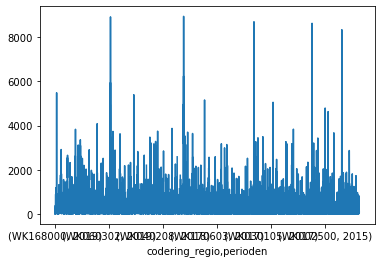

In [12]:
df_dataset_WMO['wmoclienten'].plot()

<AxesSubplot:xlabel='codering_regio,perioden'>

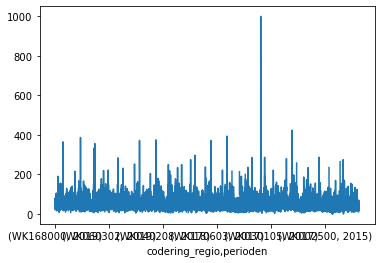

In [13]:
df_dataset_WMO['wmoclientenper1000inwoners'].plot()

In [15]:
df_dataset_WMO[df_dataset_WMO['wmoclientenper1000inwoners']==1000]

,,financieringsvorm,wmoclienten,wmoclientenper1000inwoners,gemeentenaam,AantalInwoners_5,Mannen_6,Vrouwen_7,k_0Tot15Jaar_8,k_15Tot25Jaar_9,k_25Tot45Jaar_10,k_45Tot65Jaar_11,k_65JaarOfOuder_12,Ongehuwd_13,Gehuwd_14,Gescheiden_15,Verweduwd_16,WestersTotaal_17,NietWestersTotaal_18,Marokko_19,NederlandseAntillenEnAruba_20,Suriname_21,Turkije_22,OverigNietWesters_23,GeboorteTotaal_24,GeboorteRelatief_25,SterfteTotaal_26,SterfteRelatief_27,HuishoudensTotaal_28,Eenpersoonshuishoudens_29,HuishoudensZonderKinderen_30,HuishoudensMetKinderen_31,GemiddeldeHuishoudensgrootte_32,Bevolkingsdichtheid_33,Woningvoorraad_34,GemiddeldeWoningwaarde_35,PercentageEengezinswoning_36,PercentageMeergezinswoning_37,PercentageBewoond_38,PercentageOnbewoond_39,Koopwoningen_40,HuurwoningenTotaal_41,InBezitWoningcorporatie_42,InBezitOverigeVerhuurders_43,EigendomOnbekend_44,BouwjaarVoor2000_45,BouwjaarVanaf2000_46,GemiddeldElektriciteitsverbruikTotaal_47,Appartement_48,Tussenwoning_49,Hoekwoning_50,TweeOnderEenKapWoning_51,VrijstaandeWoning_52,Huurwoning_53,EigenWoning_54,GemiddeldAardgasverbruikTotaal_55,Appartement_56,Tussenwoning_57,Hoekwoning_58,TweeOnderEenKapWoning_59,VrijstaandeWoning_60,Huurwoning_61,EigenWoning_62,PercentageWoningenMetStadsverwarming_63,AantalInkomensontvangers_64,GemiddeldInkomenPerInkomensontvanger_65,GemiddeldInkomenPerInwoner_66,k_40PersonenMetLaagsteInkomen_67,k_20PersonenMetHoogsteInkomen_68,Actieven1575Jaar_69,k_40HuishoudensMetLaagsteInkomen_70,k_20HuishoudensMetHoogsteInkomen_71,HuishoudensMetEenLaagInkomen_72,HuishOnderOfRondSociaalMinimum_73,PersonenPerSoortUitkeringBijstand_74,PersonenPerSoortUitkeringAO_75,PersonenPerSoortUitkeringWW_76,PersonenPerSoortUitkeringAOW_77,BedrijfsvestigingenTotaal_78,ALandbouwBosbouwEnVisserij_79,BFNijverheidEnEnergie_80,GIHandelEnHoreca_81,HJVervoerInformatieEnCommunicatie_82,KLFinancieleDienstenOnroerendGoed_83,MNZakelijkeDienstverlening_84,RUCultuurRecreatieOverigeDiensten_85,PersonenautoSTotaal_86,PersonenautoSBrandstofBenzine_87,PersonenautoSOverigeBrandstof_88,PersonenautoSPerHuishouden_89,PersonenautoSNaarOppervlakte_90,Motorfietsen_91,AfstandTotHuisartsenpraktijk_92,AfstandTotGroteSupermarkt_93,AfstandTotKinderdagverblijf_94,AfstandTotSchool_95,ScholenBinnen3Km_96,OppervlakteTotaal_97,OppervlakteLand_98,OppervlakteWater_99,MeestVoorkomendePostcode_100,Dekkingspercentage_101,MateVanStedelijkheid_102,Omgevingsadressendichtheid_103,TotaalDiefstalUitWoningSchuurED_78,VernielingMisdrijfTegenOpenbareOrde_79,GeweldsEnSeksueleMisdrijven_80,BedrijfsvestigingenTotaal_81,ALandbouwBosbouwEnVisserij_82,BFNijverheidEnEnergie_83,GIHandelEnHoreca_84,HJVervoerInformatieEnCommunicatie_85,KLFinancieleDienstenOnroerendGoed_86,MNZakelijkeDienstverlening_87,RUCultuurRecreatieOverigeDiensten_88,PersonenautoSTotaal_89,PersonenautoSBrandstofBenzine_90,PersonenautoSOverigeBrandstof_91,PersonenautoSPerHuishouden_92,PersonenautoSNaarOppervlakte_93,Motorfietsen_94,AfstandTotHuisartsenpraktijk_95,AfstandTotGroteSupermarkt_96,AfstandTotKinderdagverblijf_97,AfstandTotSchool_98,ScholenBinnen3Km_99,OppervlakteTotaal_100,OppervlakteLand_101,OppervlakteWater_102,MeestVoorkomendePostcode_103,Dekkingspercentage_104,MateVanStedelijkheid_105,Omgevingsadressendichtheid_106,PersonenautoSJongerDan6Jaar_87,PersonenautoS6JaarEnOuder_88,PersonenautoSBrandstofBenzine_89,PersonenautoSOverigeBrandstof_90,PersonenautoSPerHuishouden_91,PersonenautoSNaarOppervlakte_92,Motorfietsen_93,AfstandTotHuisartsenpraktijk_94,AfstandTotGroteSupermarkt_95,AfstandTotKinderdagverblijf_96,AfstandTotSchool_97,ScholenBinnen3Km_98,OppervlakteTotaal_99,OppervlakteLand_100,OppervlakteWater_101,MeestVoorkomendePostcode_102,Dekkingspercentage_103,MateVanStedelijkheid_104,Omgevingsadressendichtheid_105,TotaalDiefstalUitWoningSchuurED_106,VernielingMisdrijfTegenOpenbareOrde_107,GeweldsEnSeksueleMisdrijven_108,Bedrijfsmotorvoertuigen_93,TotaalDiefstalUitWoningSchuurED_107,VernielingMisdrijfTegenOpenbareOrde_108,GeweldsEnSeksueleMisdrijven_109,Koopwoning_54,

# Klad

In [ ]:
# # DRAAIT LANG ALS JE ALLES OPVRAAGT
# url = 'dataderden.cbs.nl'
# df_to_collect = df_tables_cbs_derden
# dict_cbs_tables = {}
# for i in df_to_collect['Identifier'][:2]:
#     print(i)
#     try:
#         df = pd.DataFrame(cbsodata.get_data(str(i), catalog_url=url))
#     except Exception:
#         df = pd.DataFrame()
#         pass
#     dict_cbs_tables[i] = df
# dict_cbs_tables['40072NED'].sample(10)

In [ ]:
# # Eerste lijst met mogelijke tabellen
# dict_tables = {'regio-indeling 2021': '84929NED',
#                'regio-indeling 2020':'84721NED', 
#                'regio-indeling 2019':'84378NED', 
#                'regio-indeling 2018':'83859NED', 
#                'regio-indeling 2017':'83553NED', 
#                'regio-indeling 2016':'83287NED',
#                 'Bevolking; geslacht, leeftijd, regio': '37259ned',
#                 'Huishoudens; samenstelling, regio': '71486ned',
#                 'Personen; afstand tot ouder, 2014': '83246NED',
#                 'Bevolking; nationaliteit en regio' : '84727NED',
#                 'Bevolking; leeftijd, regio, 2020-2050': '84525NED',
#                 'Bevolkingsontwikkeling, regio, 2020-2050': '84528NED',
#                 'doodsoorzaken':'80202ned',
#                 'Geneesmiddelen; regio (gemeente)': '83251NED',
#                 'DBC-GGZ; personen per diagnose; regio': '84859NED',
#                 'Indicatoren jeugdzorg; gemeenten': '82972NED',
#                 'Jeugdzorgcombinaties': '84136NED',
#                 'Jongeren met jeugdzorg; pers. kenmerken':'84135NED',
#                 'Trajecten jeugdzorg; regio, peildatum': '82968NED',
#                 'Gemeentelijke kosten; jeugdzorg, regio': '83454NED',
#                 'Wmo-cliënten; financiering, wijken, 2020': '84907NED',
#                 'Wmo-cliënten; financiering, wijken, 2019': '84664NED',
#                 'Wmo-cliënten; financiering, wijken, 2018': '84421NED',
#                 'Wmo-cliënten; financiering, wijken, 2017': '83818NED',
#                 'Wmo-cliënten; financiering, wijken 2016': '83620NED',
#                 'Wmo-cliënten; financiering, wijken 2015':'83267NED',
#                 'Wmo_cliënten; type, wijken, 2020': '84908NED',
#                 'Wmo-cliënten; type maatwerk, wijken 2019': '84753NED',
#                 'Wmo-cliënten; type maatwerk, wijken 2018': '84752NED',
#                 'Wmo-cliënten; type maatwerk, wijken 2017': '84751NED',
#                 'Inkomsten eigen bijdr. Wmo-maatwerkvoorz': '84578NED',
#                 'Uitgaven Wmo-maatwerkvoorz.; type, regio': '84580NED',
#                 'Wmo-cliënten die instromen in Wlz 2019': '84812NED',
#                 'Wmo-cliënten die instromen in Wlz 2018': '84599NED',
#                 'Wmo-cliënten die instromen in Wlz 2017': '84579NED',
#                 'Wmo-arrangementen; stand, regio': '83268NED',
#                 'Wmo-cliënten; reden beëindiging, regio': '83266NED',
#                 'Wmo-cliënten; type arrangement, regio':'83262NED',
#                 'Wmo-cliënten; type maatwerk; regio': '84839NED',
#                 'Wmo-gebruik; aantal arrangementen, regio': '83264NED',
#                 'Stapeling Sociaal Domein, 2020': '84906NED',
#                 'Gebruik voorz sociaal dom; wijken, 2019': '84662NED',
#                 'Gebr voorz sociaal domein; wijken, 2018': '84420NED',
#                 'Gebr voorz sociaal domein; wijken, 2017': '83817NED',
#                 'Gebr voorz sociaal domein; wijken 2016': '83619NED',
#                 'Inkomen huishoudens; kenmerken, regio': '84866NED',
#                 'Kerncijfers begrot. heffing per gemeente': '83643NED',
#                 'Gemeenterek.; taakvelden groottekl regio': '84413NED',
#                 'Gem.rekening; balans regio grootteklasse': '71231ned'}

In [ ]:
# # Crasht wegens memory problemen
# df_meta = pd.DataFrame()
# for table in dict_tables.values():
#     df = pd.DataFrame(cbsodata.get_data(table, catalog_url=url))
#     if 'RegioS' in df.columns:
#         regios = df.RegioS.unique()
#     else:
#         regios = "NOTPRESENT"
#     if 'Periode' in df.columns:
#         periode = df.Periode.unique()
#     elif 'Perioden' in df.columns:
#         periode = df.Perioden.unique()
#     else:
#         periode = "NOTPRESENT"
#     df.to_csv(f"{table}.csv")
#     df_meta = df_meta.append({'table':table, 'regios':regios, 'periode':periode}, ignore_index=True)
# df_meta.to_csv('df_meta_long.csv', sep=';')

In [ ]:
# # Get meta data
# table = '84727NED'
# print(cbsodata.get_info(table)['ShortDescription'])
# meta_data = pd.DataFrame(cbsodata.get_meta(table, "DataProperties"))
# meta_data.head(10)

In [ ]:
# # tabel te groot
# table = '84727NED'
# df = pd.DataFrame(cbsodata.get_data(table, catalog_url=url))

In [ ]:
# df_84799NED = pd.DataFrame(cbsodata.get_data('84799NED', catalog_url=CBS_OPEN_URL))
# df_84583NED = pd.DataFrame(cbsodata.get_data('84583NED', catalog_url=CBS_OPEN_URL))
# df_84286NED = pd.DataFrame(cbsodata.get_data('84286NED', catalog_url=CBS_OPEN_URL))
# df_83765NED = pd.DataFrame(cbsodata.get_data('83765NED', catalog_url=CBS_OPEN_URL))
# df_83487NED = pd.DataFrame(cbsodata.get_data('83487NED', catalog_url=CBS_OPEN_URL))
# df_83220NED = pd.DataFrame(cbsodata.get_data('83220NED', catalog_url=CBS_OPEN_URL))
# df_82931NED = pd.DataFrame(cbsodata.get_data('82931NED', catalog_url=CBS_OPEN_URL))